# Import Packages

In [4]:
import time

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nengo
import numpy as np
from PIL import Image
from skimage.transform import resize

from collections import deque
from xml.etree import ElementTree as et

from alive_progress import alive_bar
# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib
from dm_control import composer, mjcf, mujoco
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


# Define Utilities and Parameters

In [41]:
# Rendering parameters
dpi = 100
framerate = 60 # (Hz)
width, height = 720, 480
sensor_shape = (10, 10)

# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-9
_TIME_STEP = 2e-3


def display_video(frames, framerate=30, figsize=None):
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    if figsize is None:
        figsize = (width / dpi, height / dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def J_zero(physics, site_name):
    phys = mujoco.Physics.from_model(physics.model)
    jac_pos = np.zeros((3, phys.model.nv))
    jac_rot = np.zeros((3, phys.model.nv))
    mjlib.mj_jacSite(
        phys.model.ptr,
        phys.data.ptr,
        jac_pos,
        jac_rot,
        phys.model.name2id(site_name, 'site'))
    
    return jac_pos, jac_rot

# Modify Taxel Sites in The Scene XML File (if necessary)
* [Mujoco XML Reference](https://mujoco.readthedocs.io/en/latest/XMLreference.html?highlight=site#body-site)
* [The ElementTree XML API](https://docs.python.org/3/library/xml.etree.elementtree.html)

In [6]:
# Define taxel sites to place touch sensors
_N = 10
site_type = 'capsule'
dx = 3e-3
offset = dx*(_N - 1)/2.0

robot_xml = 'models/panda_nohand.xml'
tree = et.parse(robot_xml)
root = tree.getroot()
for body in root.findall('.//body'):
    if body.get('name') == 'taxel_sites':
        sites = list(body.iter('site'))
        for i, site in enumerate(sites):
            site.attrib['type'] = site_type
            site.attrib['size'] = '1e-3 2e-3'
            site.attrib['pos'] = '{:.5f} -.003 {:.5f}'.format(dx*(i//_N)-offset, dx*(i%_N)-offset) # x-z-y axis
            site.attrib['euler'] = '1.570796 0 0'
tree.write(robot_xml) # Save robot XML

## Tactile Sensor

### Soft Sensor Pad (array of balls)
* _M: (x/y-count, z-count)

### Taxel Sites
* site_type: [sphere, capsule, ellipsoid, cylinder, box], “sphere”
* dx: the distance between each site
* offset: uniform distance to shift all sites

### Tendons for planar connections

In [86]:
# Define 3D arrays of balls connected with sliders
_M = (15, 1)
radius = 5e-4
mass = 1e-12/np.prod(_M)
dx = (3e-2-2*radius)/(_M[0] - 1)
offset = dx*(_M[0] - 1)/2.0
geom_type = 'sphere'
site_type = 'capsule'

robot_xml = 'models/panda_nohand.xml'
tree = et.parse(robot_xml)
root = tree.getroot()
for body in root.findall('.//body'):
    if body.get('name') == 'sensor_pad':
        sensor_pad = body

# If balls and tendons are already defined, remove them first
if sensor_pad.find('body') is not None:
    for body in sensor_pad.findall('body'):
        sensor_pad.remove(body)
tendon = root.find('tendon')
if tendon is not None:
    for spatial in tendon.findall('spatial'):
        tendon.remove(spatial)
        

def create_linked_ball(sid, pos, euler, springdamper=(1e-2, 1)):
    # Create base ball
    elem = et.Element('body')
    elem.set('name', 'taxel' + str(sid))
    elem.set('pos', '{:.6f} {:.6f} {:.6f}'.format(pos[0], pos[1], pos[2]))
    elem.set('euler', euler)
    # Inertia
    inertia = et.Element('inertial')
    inertia.set('mass', str(mass))
    inertia.set('pos', '0 0 0')
    inertia.set('fullinertia', '1e-6 1e-6 1e-6 0 0 0')
    # Joint
    joint = et.Element('joint')
    joint.set('type', 'slide')
    joint.set('axis', '0 0 1')
    joint.set('springdamper', '{} {}'.format(springdamper[0], springdamper[1]))
    joint.set('frictionloss', '1e-2')
    # Geom
    geom = et.Element('geom')
    geom.set('name', 'ball' + str(sid))
    geom.set('type', geom_type)
    geom.set('size', str(radius))
    geom.set('class', 'collision')
    # Site
    site = et.Element('site')
    site.set('name', 'tendon_site' + str(sid))
    site.set('type', 'sphere')
    site.set('size', '1e-4')
    site.set('group', '1')
    # Add to dynamic tree
    elem.append(inertia)
    elem.append(joint)
    elem.append(geom)
    elem.append(site)
    return elem


def create_tendon(tid, site_names):
    spatial = et.Element('spatial')
    spatial.set('name', 'tendom'+str(tid))
    spatial.set('width', '2e-4')
    spatial.set('limited', 'true')
    spatial.set('range', '0 {:.6f}'.format(4*dx))
    spatial.set('frictionloss', '1e-2')
    spatial.set('stiffness', '0.1')
    spatial.set('damping', '0.5')
    for sn in site_names:
        site = et.Element('site')
        site.set('site', sn)
        spatial.append(site)
    return spatial
        
        
# Define balls with sliders and touch sensors
sid = 0
for i in range(_M[0]):
    for j in range(_M[0]):
        sid += 1
        parent = create_linked_ball(sid, (dx*i-offset, dx*j-offset, 1e-3), '0 0 0', (2e-3, 0.9))
        #child = create_linked_ball(sid + _M[0]*_M[0], (0, 0, 2e-3), '0 0 0', (1e-3, 0.9))
        #parent.append(child)
        sensor_pad.append(parent)

# Define tendons
tid = 0
for m in range(_M[0]):
    for n in range(_M[0]):
        tid += 1
        if n != _M[0] - 1:
            site_ids = [n + 1 + k + m*_M[0] for k in range(2)]
            spatial = create_tendon(tid, ['tendon_site' + str(i) for i in site_ids])
            tendon.append(spatial)
        if m != _M[0] - 1:
            tid += 1
            site_ids = [n + 1 + (m + k)*_M[0] for k in range(2)]
            spatial = create_tendon(tid, ['tendon_site' + str(i) for i in site_ids])
            tendon.append(spatial)


tree.write(robot_xml) # Save robot

## Key Frames
* Initial poses

In [8]:
# Modify the keyframe home key qpos
njoints = _M[0]*_M[0]*_M[1] + 10
scene_xml = 'models/scene.xml'
tree = et.parse(scene_xml)
root = tree.getroot()
key = root.find('.//keyframe/key')
qpos_value = '0 0 0 -1.570796 0 1.570796 0.785398 0 0 0'
key.attrib['ctrl'] = qpos_value
if njoints > 10:
    qpos_value += ' '  + ' '.join(['0' for i in range(njoints - 10)])
key.attrib['qpos'] = qpos_value
tree.write(scene_xml)

# Run Simulations

In [87]:
# Load scene
scene_xml = 'models/scene.xml'
physics = mujoco.Physics.from_xml_path(scene_xml)

# Define simulation variables
site_name = 'attachment_site'
control_site = physics.data.site(name=site_name)
target_site = physics.data.site(name='reach_site3')
joint_names = ['joint{}'.format(i+1) for i in range(7)]
ctrl = np.zeros(10)
duration = 3.0 # (seconds)
omega = 2*np.pi/duration # Rotator angular velocity
video = []
stream = []
contacts = []

# Simulate, saving video frames
physics.reset(1)
ctrl[:7] = physics.data.qpos[:7]
xpos = control_site.xpos
with alive_bar(int(duration/_TIME_STEP) + 1, force_tty=True, title='Rendering') as bar:
    while physics.data.time < duration:
        ctrl[-3:] = np.array([1, 1, 1])*omega*physics.data.time
        physics.set_control(ctrl)
        physics.step()
        
        pressure = physics.named.data.qpos[7:-3].reshape((_M[0], _M[0]))
        stream.append(np.expand_dims(pressure, -1))
        
        # Save video frames and sensor data
        if len(video) < physics.data.time * framerate:
            pixels = physics.render(camera_id='prospective', width=width, height=height)
            video.append(pixels.copy())
            
        # Update progress 
        bar()

# PIL.Image.fromarray(image)
display_video(video, framerate)

Rendering |████████████████████████████████████████| 1501/1501 [100%] in 7.3s (205.17/s)                                


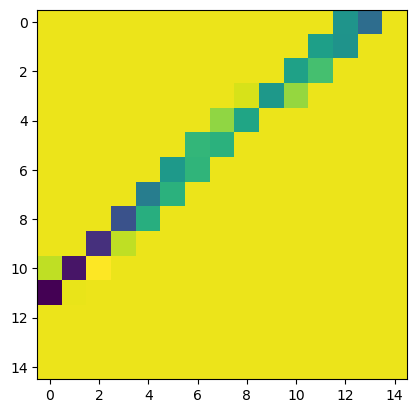

In [90]:
plt.imshow(stream[0])